In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os,cv2
import pickle
import random
from hashlib import md5
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

In [2]:
# Define paths
data_path = "faces_emotions_data"

# Define class labels
class_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', "Surprise"]

In [3]:
# Helper function to load images, label them, and save to pickle files
def load_label_and_pickle_images(data_path, class_labels, output_file):
    img_data_list = []
    img_labels_list = []

    for label in class_labels:
        img_dir = os.path.join(data_path, label)
        img_list = os.listdir(img_dir)
        print(f'The images of the dataset {label} were loaded successfully\n')

        for img in img_list:
            img_path = os.path.join(img_dir, img)
            input_img = cv2.imread(img_path)

            if input_img is None:
                print(f'Failed to load image: {img_path}')
                continue

            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_resize = cv2.resize(input_img, (48, 48))
            img_data_list.append(input_img_resize)
            img_labels_list.append(label)

    # Convert to numpy array and normalize
    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    img_data = img_data / 255.0

    # Convert labels to numpy array
    img_labels = np.array(img_labels_list)

    # Save images and labels to a pickle file
    with open(output_file, 'wb') as f:
        pickle.dump((img_data, img_labels), f)

    print(f'{output_file} has been saved with shape {img_data.shape} and labels shape {img_labels.shape}')

In [4]:
#Execute Function
output_file = 'images_labels.pkl'
load_label_and_pickle_images(data_path, class_labels, output_file)

The images of the dataset Anger were loaded successfully

The images of the dataset Contempt were loaded successfully

The images of the dataset Disgust were loaded successfully

The images of the dataset Fear were loaded successfully

The images of the dataset Happiness were loaded successfully

The images of the dataset Neutral were loaded successfully

The images of the dataset Sadness were loaded successfully

The images of the dataset Surprise were loaded successfully

images_labels.pkl has been saved with shape (5558, 48, 48) and labels shape (5558,)


In [5]:
# Function to load images, label them, and save to pickle files
def load_label_and_pickle_images(data_path, class_labels):
    img_data_list = []
    img_labels_list = []

    img_hash_dict = {}  # To keep track of image hashes across all folders

    for label in class_labels:
        img_dir = os.path.join(data_path, label)
        img_list = os.listdir(img_dir)
        print(f'The images of the dataset {label} were loaded successfully\n')

        for img in img_list:
            img_path = os.path.join(img_dir, img)

            input_img = cv2.imread(img_path)

            if input_img is None:
                print(f'Failed to load image: {img_path}')
                continue

            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_resize = cv2.resize(input_img, (48, 48))

            # Compute hash of the image
            img_hash = md5(input_img_resize).hexdigest()

            if img_hash in img_hash_dict:
                print(f'Removing duplicate image: {img_path} (duplicate of {img_hash_dict[img_hash]})')
                continue  # Skip adding this duplicate image
            else:
                img_hash_dict[img_hash] = img_path

            img_data_list.append(input_img_resize)
            img_labels_list.append(label)

    # Convert to numpy array and normalize
    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    img_data = img_data / 255.0

    # Convert labels to numpy array
    img_labels = np.array(img_labels_list)

    # Save images and labels to a pickle file
    with open('images_labels_no_duplicates.pkl', 'wb') as f:
        pickle.dump((img_data, img_labels), f)

    print(f'images_labels_no_duplicates.pkl has been saved with shape {img_data.shape} and labels shape {img_labels.shape}')

# Execute the function
data_path = "faces_emotions_data"
class_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']
load_label_and_pickle_images(data_path, class_labels)

The images of the dataset Anger were loaded successfully

Removing duplicate image: faces_emotions_data\Anger\images - 2020-11-06T003628.925_face.png (duplicate of faces_emotions_data\Anger\9k__face.png)
Removing duplicate image: faces_emotions_data\Anger\images - 2020-11-06T004032.118_face.png (duplicate of faces_emotions_data\Anger\images - 2020-11-06T003550.427_face.png)
Removing duplicate image: faces_emotions_data\Anger\images - 2020-11-06T004037.943_face.png (duplicate of faces_emotions_data\Anger\images - 2020-11-06T003708.842_face.png)
Removing duplicate image: faces_emotions_data\Anger\images - 2020-11-06T004045.846_face.png (duplicate of faces_emotions_data\Anger\images - 2020-11-06T003720.067_face.png)
Removing duplicate image: faces_emotions_data\Anger\images - 2020-11-06T004110.233_face.png (duplicate of faces_emotions_data\Anger\images - 2020-11-06T003744.820_face.png)
Removing duplicate image: faces_emotions_data\Anger\images - 2020-11-06T004129.030_face.png (duplicate o

In [6]:
# Helper function to load the pickled data and verify the images
def verify_images(dataset_file):
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Randomly pick and plot one image from each class
    plt.figure(figsize=(16, 8))

    unique_labels = np.unique(img_labels)
    for idx, label in enumerate(unique_labels):
        # Get all images for the current label
        label_images = img_data[img_labels == label]

        # Randomly select one image
        random_image = random.choice(label_images)

        plt.subplot(2, 4, idx + 1)
        plt.imshow(random_image, cmap='gray')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

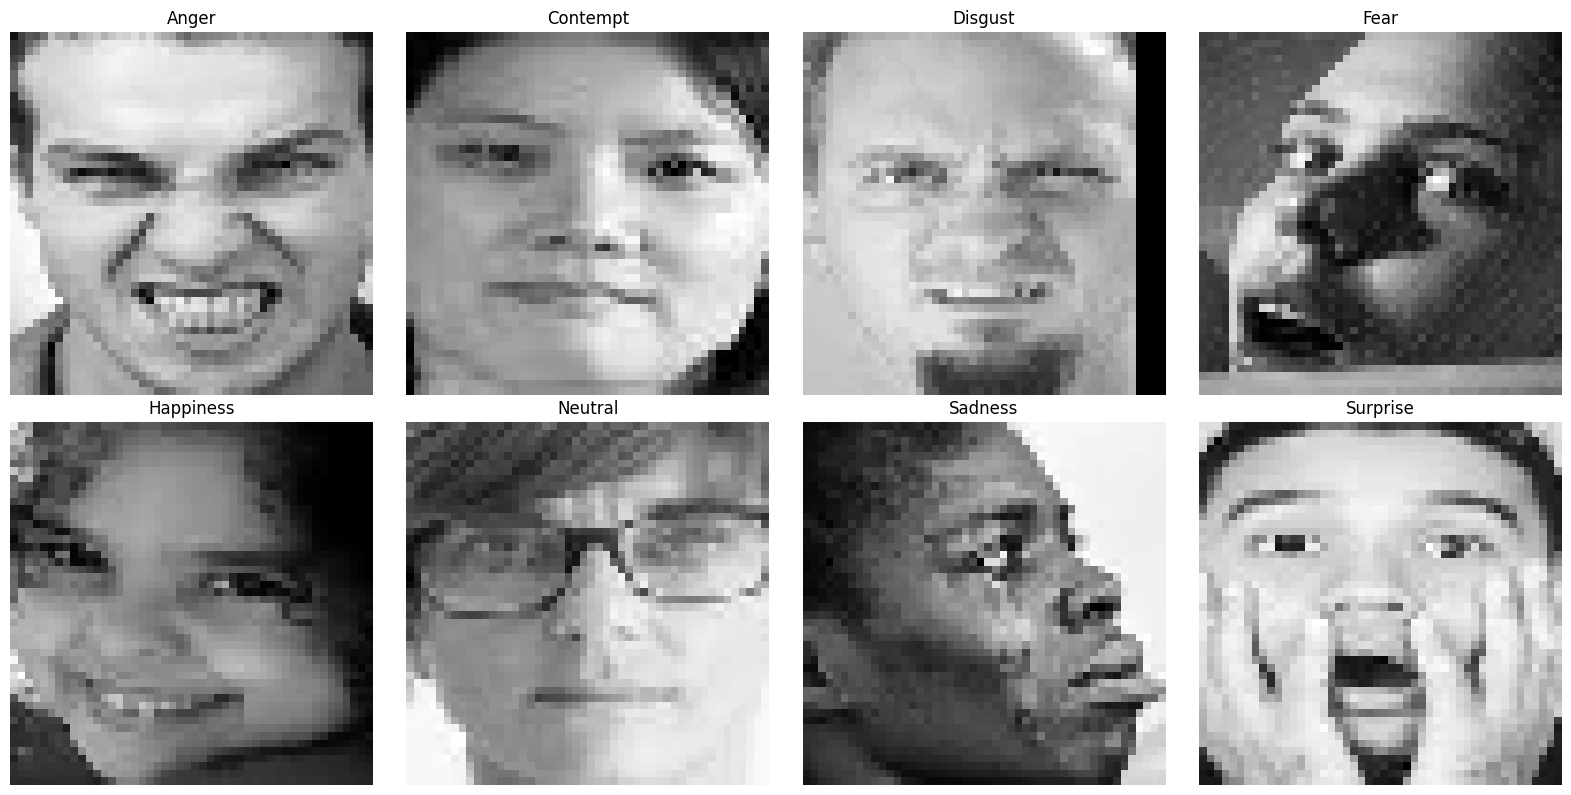

In [7]:
# Specify the input dataset file
dataset_file = 'images_labels.pkl'

# Execute the verification function
verify_images(dataset_file)

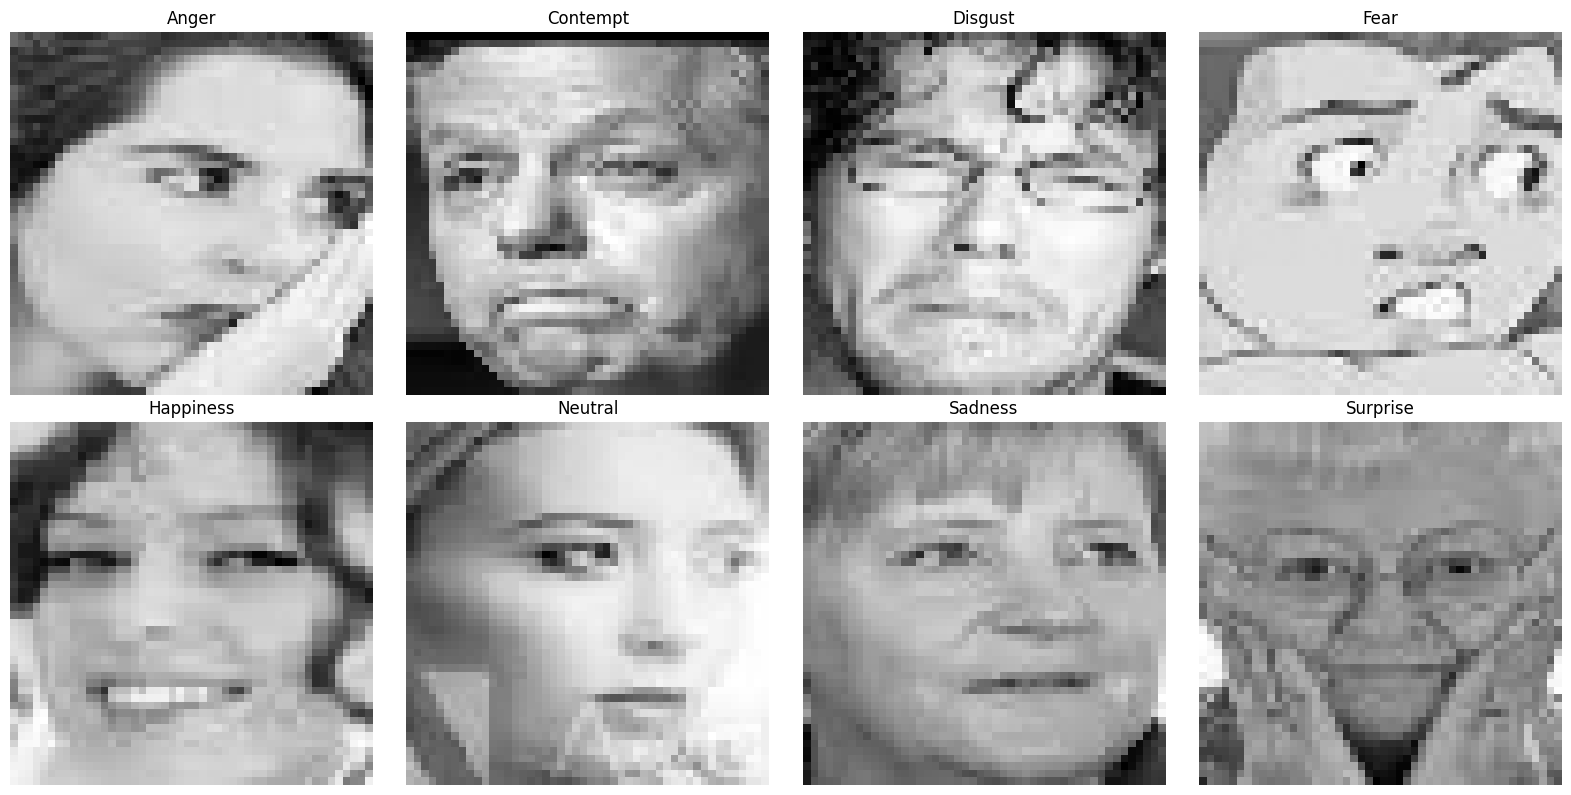

In [8]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates.pkl'

# Execute the verification function
verify_images(dataset_file)

In [9]:
#Helper function to cont and plot the items for each label
def count_items_in_classes(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Count the occurrences of each label
    unique_labels, counts = np.unique(img_labels, return_counts=True)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Emotion Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

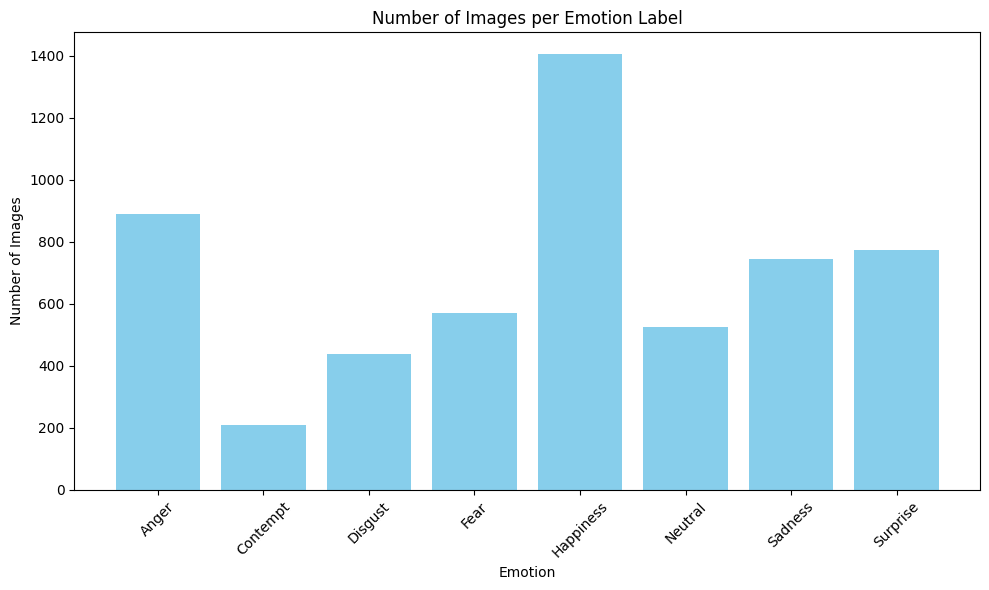

In [10]:
# Specify the input dataset file
dataset_file = 'images_labels.pkl'

# Execute the verification function
count_items_in_classes(dataset_file)

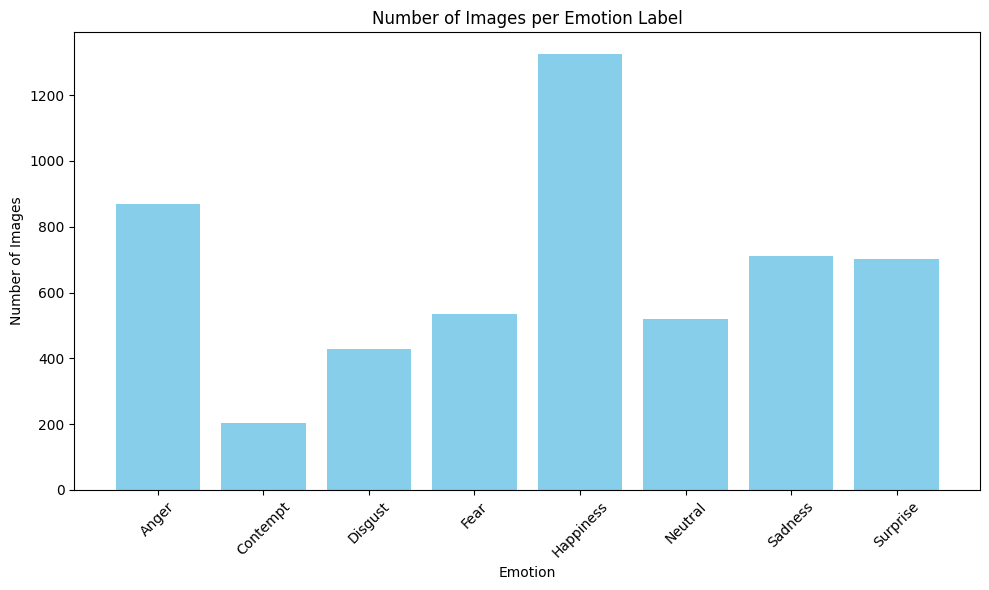

In [11]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates.pkl'

# Execute the verification function
count_items_in_classes(dataset_file)

In [12]:
# Define the data augmentation transforms
data_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    #transforms.ColorJitter(contrast=0.1, saturation=0.1, brightness=0.1, hue=0.1), #we remove colorjitter because it can impair the display of microexpressions TODO: delete?
])

def augment_images(img_data, target_count, label):
    augmented_images = []
    while len(augmented_images) + len(img_data) < target_count:
        for img in img_data:
            if len(augmented_images) + len(img_data) >= target_count:
                break
            img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Convert to PIL image
            augmented_img = data_transforms(img_pil)  # Apply transforms
            augmented_img = np.array(augmented_img).astype('float32') / 255.0  # Normalize back to 0-1 range
            augmented_images.append(augmented_img)
        print(f'{label}: {len(augmented_images)} augmented images generated so far')
    return np.array(augmented_images)

def balance_dataset(input_pickle_file, output_pickle_file):
    # Load the data from the pickle file
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Combine images and labels into a dictionary
    img_data_dict = {label: [] for label in set(img_labels)}
    for img, label in zip(img_data, img_labels):
        img_data_dict[label].append(img)

    # Find the maximum class size
    max_class_size = max(len(img_list) for img_list in img_data_dict.values())

    # Balance the dataset
    balanced_img_data_dict = {}

    for label, img_list in img_data_dict.items():
        img_list = np.array(img_list).astype('float32')
        print(f'Processing {label}, {len(img_list)} images')
        if len(img_list) < max_class_size:
            augmented_imgs = augment_images(img_list, max_class_size, label)
            balanced_img_data_dict[label] = np.concatenate((img_list, augmented_imgs), axis=0)
        else:
            balanced_img_data_dict[label] = img_list

        with open(f'{label}_balanced_images.pkl', 'wb') as f:
            pickle.dump(balanced_img_data_dict[label], f)
        print(f'{label}_balanced_images.pkl has been saved with shape {balanced_img_data_dict[label].shape}')

    # Save the entire balanced dataset into a single pickle file
    with open(output_pickle_file, 'wb') as f:
        pickle.dump(balanced_img_data_dict, f)
    print(f'{output_pickle_file} has been saved')

In [13]:
input_pickle_file = 'images_labels_no_duplicates.pkl'
output_pickle_file = 'balanced_images_labels.pkl'
balance_dataset(input_pickle_file, output_pickle_file)

Processing Anger, 868 images
Anger: 457 augmented images generated so far
Anger_balanced_images.pkl has been saved with shape (1325, 48, 48)
Processing Sadness, 711 images
Sadness: 614 augmented images generated so far
Sadness_balanced_images.pkl has been saved with shape (1325, 48, 48)
Processing Disgust, 428 images
Disgust: 428 augmented images generated so far
Disgust: 856 augmented images generated so far
Disgust: 897 augmented images generated so far
Disgust_balanced_images.pkl has been saved with shape (1325, 48, 48)
Processing Surprise, 702 images
Surprise: 623 augmented images generated so far
Surprise_balanced_images.pkl has been saved with shape (1325, 48, 48)
Processing Neutral, 518 images
Neutral: 518 augmented images generated so far
Neutral: 807 augmented images generated so far
Neutral_balanced_images.pkl has been saved with shape (1325, 48, 48)
Processing Fear, 534 images
Fear: 534 augmented images generated so far
Fear: 791 augmented images generated so far
Fear_balanc

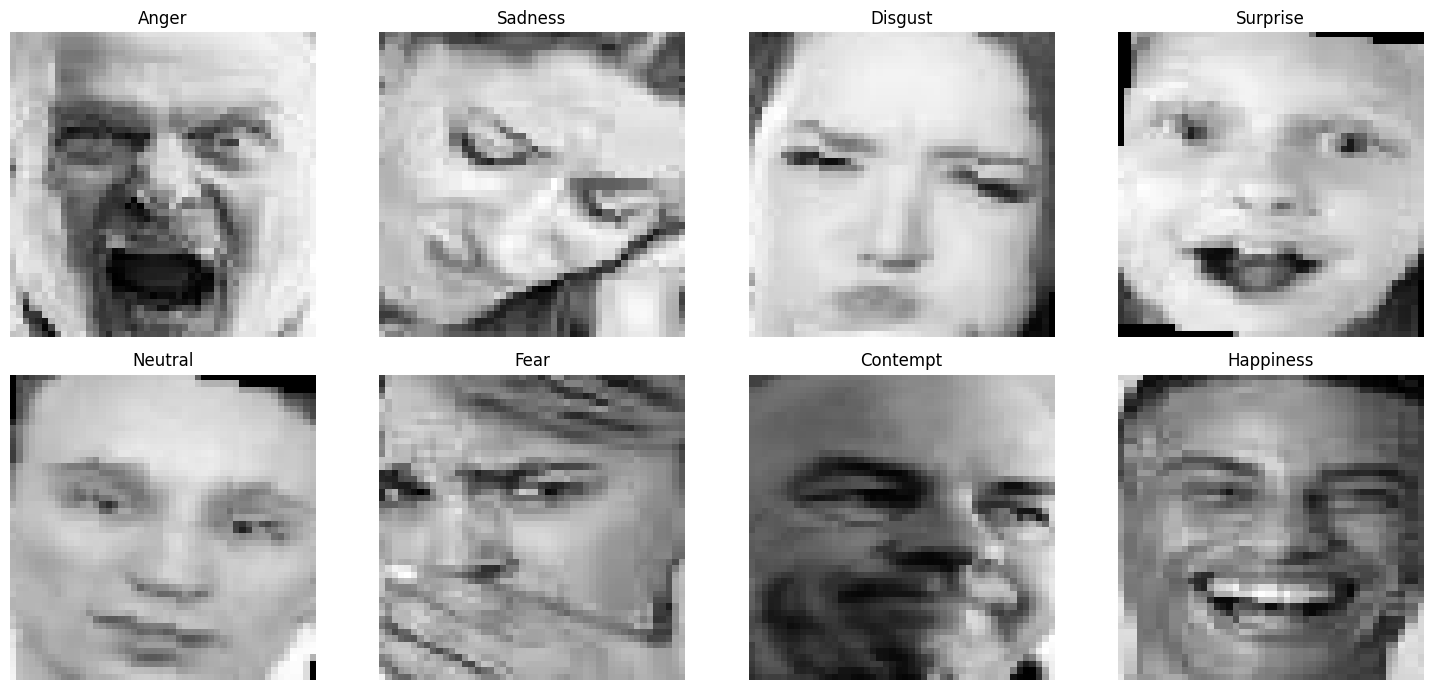

In [14]:
# Visualize a few samples to ensure the data augmentation worked correctly
with open(output_pickle_file, 'rb') as f:
    balanced_img_data_dict = pickle.load(f)

fig, axs = plt.subplots(2, 4, figsize=(15, 7))
for i, label in enumerate(balanced_img_data_dict.keys()):
    img_data = balanced_img_data_dict[label]
    img_idx = random.randint(0, len(img_data) - 1)
    img = img_data[img_idx]
    ax = axs[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def count_items_in_classes_2(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)

    # Count the number of items in each class
    for label, img_list in balanced_img_data_dict.items():
        print(f'{label}: {len(img_list)} images')

In [16]:
# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the verification function
count_items_in_classes_2(dataset_file)

Anger: 1325 images
Sadness: 1325 images
Disgust: 1325 images
Surprise: 1325 images
Neutral: 1325 images
Fear: 1325 images
Contempt: 1325 images
Happiness: 1325 images


In [17]:
# Load the data from the pickle file
with open('images_labels_no_duplicates.pkl', 'rb') as f:
    img_data, img_labels = pickle.load(f)

# Print out some basic information about the data
print(f'Loaded data shape: {img_data.shape}')
print(f'Loaded labels shape: {img_labels.shape}')
print(f'Unique labels: {set(img_labels)}')

Loaded data shape: (5289, 48, 48)
Loaded labels shape: (5289,)
Unique labels: {'Anger', 'Sadness', 'Disgust', 'Surprise', 'Neutral', 'Fear', 'Contempt', 'Happiness'}


In [18]:
def inspect_balanced_dataset(file_path):
    # Load the balanced dataset
    with open(file_path, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)

    # Initialize lists to collect all images and labels
    all_images = []
    all_labels = []

    # Iterate through the dictionary to collect data
    for label, img_list in balanced_img_data_dict.items():
        all_images.extend(img_list)
        all_labels.extend([label] * len(img_list))

    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Print the required information
    print(f'Loaded data shape: {all_images.shape}')
    print(f'Loaded labels shape: {all_labels.shape}')
    print(f'Unique labels: {set(all_labels)}')

# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the inspection function
inspect_balanced_dataset(dataset_file)

Loaded data shape: (10600, 48, 48)
Loaded labels shape: (10600,)
Unique labels: {'Anger', 'Disgust', 'Surprise', 'Neutral', 'Happiness', 'Sadness', 'Contempt', 'Fear'}


CNN1

In [19]:
# Load the data from a pickle file
balanced_data = pd.read_pickle('balanced_images_labels.pkl')

In [20]:
#See how many elements we have for each class, like we did in the previous notebook.
def count_items_in_classes_2(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)

    # Count the number of items in each class
    for label, img_list in balanced_img_data_dict.items():
        print(f'{label}: {len(img_list)} images')

In [21]:
# Execute the verification function
count_items_in_classes_2(dataset_file)

Anger: 1325 images
Sadness: 1325 images
Disgust: 1325 images
Surprise: 1325 images
Neutral: 1325 images
Fear: 1325 images
Contempt: 1325 images
Happiness: 1325 images


In [22]:
#Inspect the shape of the data
def inspect_balanced_dataset(file_path):
    # Load the balanced dataset
    with open(file_path, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)

    # Initialize lists to collect all images and labels
    all_images = []
    all_labels = []

    # Iterate through the dictionary to collect data
    for label, img_list in balanced_img_data_dict.items():
        all_images.extend(img_list)
        all_labels.extend([label] * len(img_list))

    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Print the required information
    print(f'Loaded data shape: {all_images.shape}')
    print(f'Loaded labels shape: {all_labels.shape}')
    print(f'Unique labels: {set(all_labels)}')

# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the inspection function
inspect_balanced_dataset(dataset_file)

Loaded data shape: (10600, 48, 48)
Loaded labels shape: (10600,)
Unique labels: {'Anger', 'Disgust', 'Surprise', 'Neutral', 'Happiness', 'Sadness', 'Contempt', 'Fear'}


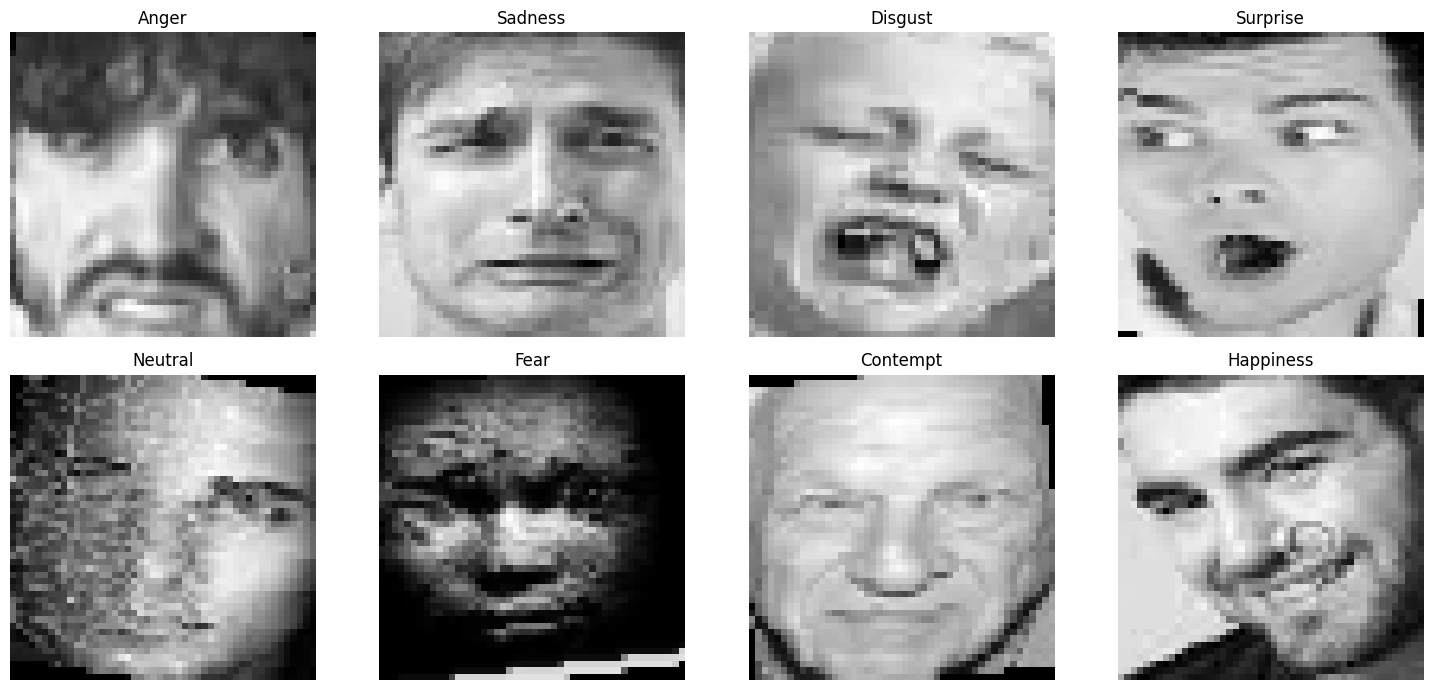

In [23]:
# Visualize a few samples to ensure the data is labelled correctly
with open(dataset_file, 'rb') as f:
    balanced_img_data_dict = pickle.load(f)

fig, axs = plt.subplots(2, 4, figsize=(15, 7))
for i, label in enumerate(balanced_img_data_dict.keys()):
    img_data = balanced_img_data_dict[label]
    img_idx = random.randint(0, len(img_data) - 1)
    img = img_data[img_idx]
    ax = axs[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Load the balanced dataset
with open('balanced_images_labels.pkl', 'rb') as f:
    balanced_img_data_dict = pickle.load(f)

# Initialize lists to collect all images and labels
all_images = []
all_labels = []

# Iterate through the dictionary to collect data
for label, img_list in balanced_img_data_dict.items():
    all_images.extend(img_list)
    all_labels.extend([label] * len(img_list))

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Add channel dimension to images
all_images = np.expand_dims(all_images, axis=1)

# Print the new shape
print(f'Images shape with channel dimension: {all_images.shape}')

Images shape with channel dimension: (10600, 1, 48, 48)


In [25]:
# Encode labels as integers
label_to_int = {label: idx for idx, label in enumerate(set(all_labels))}
all_labels_int = np.array([label_to_int[label] for label in all_labels])

# Print the encoded labels
print("Label encoding:")
for label, idx in label_to_int.items():
    print(f'{label}: {idx}')



# Encode labels as integers
label_to_int = {label: idx for idx, label in enumerate(set(all_labels))}
all_labels_int = np.array([label_to_int[label] for label in all_labels])

# Print the encoded labels
print("Label encoding:")
for label, idx in label_to_int.items():
    print(f'{label}: {idx}')

Label encoding:
Anger: 0
Disgust: 1
Surprise: 2
Neutral: 3
Happiness: 4
Sadness: 5
Contempt: 6
Fear: 7
Label encoding:
Anger: 0
Disgust: 1
Surprise: 2
Neutral: 3
Happiness: 4
Sadness: 5
Contempt: 6
Fear: 7


In [26]:
# Create the reverse mapping
int_to_label = {idx: label for label, idx in label_to_int.items()}

# Save the label mapping dictionaries for later use
with open('label_mapping.pkl', 'wb') as f:
    pickle.dump({'label_to_int': label_to_int, 'int_to_label': int_to_label}, f)
print('label_mapping.pkl has been saved')

label_mapping.pkl has been saved


In [27]:
# Convert to PyTorch tensors
all_images_tensor = torch.tensor(all_images, dtype=torch.float32)
all_labels_tensor = torch.tensor(all_labels_int, dtype=torch.int64)

# Combine into a dataset
dataset = TensorDataset(all_images_tensor, all_labels_tensor)

In [28]:
# Calculate lengths for train, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print out the sizes of the resulting datasets
print(f'Training data size: {len(train_dataset)}')
print(f'Validation data size: {len(val_dataset)}')
print(f'Test data size: {len(test_dataset)}')

Training data size: 7419
Validation data size: 1590
Test data size: 1591


In [29]:
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
# Verify the shapes
for images, labels in train_loader:
    print(f'Batch images shape: {images.shape}')
    print(f'Batch labels shape: {labels.shape}')
    break

Batch images shape: torch.Size([32, 1, 48, 48])
Batch labels shape: torch.Size([32])


In [31]:
# Save the datasets
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)
print('train_dataset.pkl has been saved')

with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)
print('val_dataset.pkl has been saved')

with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)
print('test_dataset.pkl has been saved')

train_dataset.pkl has been saved
val_dataset.pkl has been saved
test_dataset.pkl has been saved


In [32]:
# Load the data from a pickle file
train_dataset = pd.read_pickle('train_dataset.pkl')
val_dataset = pd.read_pickle('val_dataset.pkl')
test_dataset = pd.read_pickle('test_dataset.pkl')
label_mapping = pd.read_pickle('label_mapping.pkl')

In [33]:
# Let's build our model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # Adjust input size
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        x = x.view(-1, 256 * 3 * 3)  # Adjust flatten size
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)
        return x

In [34]:
model_1 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_1.to(device)

# Summarize the model
summary(model_1, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [35]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 256 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)

        return x

In [36]:
model_2 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_2.to(device)

# Summarize the model
summary(model_2, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [37]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.10)
        self.dropout2 = nn.Dropout(p=0.10)
        self.dropout3 = nn.Dropout(p=0.10)
        self.dropout4 = nn.Dropout(p=0.10)
        self.dropout5 = nn.Dropout(p=0.10)
        self.dropout6 = nn.Dropout(p=0.10)
        self.dropout7 = nn.Dropout(p=0.10)
        self.dropout8 = nn.Dropout(p=0.10)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)  # Final layer to output 8 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 256 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)  # No activation function here to return logits

        return x

In [38]:
model_3 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_3.to(device)

# Summarize the model
summary(model_3, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [39]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.10)
        self.dropout2 = nn.Dropout(p=0.10)
        self.dropout3 = nn.Dropout(p=0.10)
        self.dropout4 = nn.Dropout(p=0.10)
        self.dropout5 = nn.Dropout(p=0.10)
        self.dropout6 = nn.Dropout(p=0.10)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 8)  # Adding the final fully connected layer for 8 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 256 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # Output layer without activation

        return x

In [40]:
model_4 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_4.to(device)

# Summarize the model
summary(model_4, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [41]:
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)  # Directly map to output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 256 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the final layer

        return x

In [42]:
model_5 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_5.to(device)

# Summarize the model
summary(model_5, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [43]:
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)  # Directly map to output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 256 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the final layer

        return x

In [44]:
model_6 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_6.to(device)

# Summarize the model
summary(model_6, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [45]:
# Model with 3 convolutional layers
class CNNModel3Conv(nn.Module):
    def __init__(self):
        super(CNNModel3Conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Adjust input size according to final output size after conv layers
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 8)  # Output 8 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 48x48 -> 24x24
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))  # 24x24 -> 12x12
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))  # 12x12 -> 6x6
        x = self.dropout3(x)

        x = x.view(-1, 128 * 6 * 6)  # Flatten the tensor according to the output size from conv layers
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)
        return x

In [46]:
model_7 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_7.to(device)

# Summarize the model
summary(model_7, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [47]:
# Model with an additional hidden layer
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # Adjust input size
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)  # New hidden layer
        self.dropout6 = nn.Dropout(p=0.25)  # Dropout for new hidden layer
        self.fc3 = nn.Linear(256, 8)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 48x48 -> 24x24
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))  # 24x24 -> 12x12
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))  # 12x12 -> 6x6
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))  # 6x6 -> 3x3
        x = self.dropout4(x)

        x = x.view(-1, 256 * 3 * 3)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))  # New hidden layer
        x = self.dropout6(x)  # Dropout for new hidden layer
        x = self.fc3(x)  # Output layer
        return x

In [48]:
model_8 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_8.to(device)

# Summarize the model
summary(model_8, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [49]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)
        self.dropout8 = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 256 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)

        return x

In [50]:
model_9 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_9.to(device)

# Summarize the model
summary(model_9, input_size=(1, 48, 48), batch_size=1, device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
         MaxPool2d-2            [1, 32, 24, 24]               0
           Dropout-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
         MaxPool2d-5            [1, 64, 12, 12]               0
           Dropout-6            [1, 64, 12, 12]               0
            Conv2d-7           [1, 128, 12, 12]          73,856
         MaxPool2d-8             [1, 128, 6, 6]               0
           Dropout-9             [1, 128, 6, 6]               0
           Conv2d-10             [1, 256, 6, 6]         295,168
        MaxPool2d-11             [1, 256, 3, 3]               0
          Dropout-12             [1, 256, 3, 3]               0
           Linear-13                   [1, 512]       1,180,160
          Dropout-14               

In [51]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam  # Define optimizer without specific parameters to accommodate for different models
optimizer_2 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
checkpoint_interval = 5  # Save model weights every 5 epochs

# Set number of epochs
num_epochs = 50

In [52]:
#Train the model
def train_model(model, model_name, criterion, optimizer, train_loader,
                val_loader, device, num_epochs, patience,
                checkpoint_interval):
    """
    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - model_name (str): The name to use for saving the model and accuracies.
    - criterion (torch.nn.modules.loss._Loss): The loss function used for training.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - device (torch.device): Device (cpu or cuda) on which to perform computations.
    - num_epochs (int): Number of epochs to train the model.
    - patience (int): Number of epochs to wait for improvement in validation accuracy before stopping early.
    - checkpoint_interval (int): Interval (in epochs) at which to save model checkpoints.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    - val_accuracies (list): List of validation accuracies for each epoch.
    """
    model = model.to(device)
    model.train()  # Set the model to training mode

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_accuracy = 100 * correct / total
        train_accuracies.append(epoch_train_accuracy)
        train_losses.append(running_loss / len(train_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]}, Accuracy: {epoch_train_accuracy}%')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracies.append(epoch_val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f'Validation Loss: {val_losses[-1]}, Accuracy: {epoch_val_accuracy}%')

        # Check for early stopping
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch + 1}. Best validation accuracy: {best_val_accuracy}%')
            model.load_state_dict(best_model_wts)
            break

        # Save model checkpoint every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_filename = f'{model_name}_checkpoint_epoch_{epoch + 1}.pth'
            torch.save(model.state_dict(), checkpoint_filename)
            print(f'Checkpoint saved at epoch {epoch + 1}')

    # Load the best model weights before early stopping
    model.load_state_dict(best_model_wts)

    # Save the best model weights
    model_filename = f'{model_name}_best_model.pth'
    torch.save(model.state_dict(), model_filename)
    print(f'Best model saved as {model_filename}')

    # Save the accuracies and model name
    with open(f'{model_name}_accuracies.pkl', 'wb') as f:
        pickle.dump((model_name, train_accuracies, val_accuracies), f)

    return train_losses, train_accuracies, val_losses, val_accuracies

In [53]:
#Test the model
def evaluate_model(model, criterion, test_loader, device, model_name):
    """
    Args:
    - model (torch.nn.Module): The trained neural network model.
    - criterion (torch.nn.modules.loss._Loss): The loss function used for training.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - device (torch.device): Device (cpu or cuda) on which to perform computations.
    - model_name (str): The name or identifier of the model.

    Returns:
    - test_loss (float): Average loss on the test set.
    - test_accuracy (float): Accuracy on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            test_loss += loss.item()  # Accumulate test loss

            _, predicted = torch.max(outputs.data, 1)  # Get predictions
            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

    test_accuracy = 100 * correct / total

    # Save the test results in a pickle file
    test_results = {
        'test_loss': test_loss / len(test_loader),
        'test_accuracy': test_accuracy
    }
    output_pickle_file = f'{model_name}_test_results.pkl'
    with open(output_pickle_file, 'wb') as f:
        pickle.dump(test_results, f)

    return test_loss / len(test_loader), test_accuracy

In [54]:
# Plot the model performance after training
def plot_training_progress(training_results):

    """
    Plot training and validation accuracies across epochs for multiple models.

    Args:
    - training_results (list of tuples): List of tuples containing model names and their respective training and validation accuracies.
      Each tuple should be in the form: (model_name, train_accuracies, val_accuracies).
    """
    plt.figure(figsize=(10, 5))

    # Plot training and validation accuracies
    for result in training_results:
        model_name, train_accuracies, val_accuracies = result
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, label=f'Training Accuracy - {model_name}')
        plt.plot(epochs, val_accuracies, label=f'Validation Accuracy - {model_name}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:
#Plot the results after testing
def plot_training_validation_test(train_accuracies, val_accuracies, test_accuracy, model_names):
    """
    Plot training, validation, and test accuracy across epochs for multiple models.

    Args:
    - train_accuracies (list of lists): List of lists of training accuracies for each epoch for each model.
    - val_accuracies (list of lists): List of lists of validation accuracies for each epoch for each model.
    - test_accuracy (list): List of accuracies on the test set for each model.
    - model_names (list of str): List of model names corresponding to each set of accuracies.
    """
    plt.figure(figsize=(10, 5))

    # Plot training accuracies
    for i in range(len(train_accuracies)):
        plt.plot(range(1, len(train_accuracies[i]) + 1), train_accuracies[i], label=f'Training Accuracy - {model_names[i]}')

    # Plot validation accuracies
    for i in range(len(val_accuracies)):
        plt.plot(range(1, len(val_accuracies[i]) + 1), val_accuracies[i], label=f'Validation Accuracy - {model_names[i]}')

    # Plot test accuracies
    for i in range(len(test_accuracy)):
        plt.axhline(y=test_accuracy[i], color='r', linestyle='--', label=f'Test Accuracy - {model_names[i]}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation, and Test Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

In [56]:
train_model(model_1, model_name="Model 1", criterion=criterion, optimizer=optimizer(model_1.parameters(), lr=0.001),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 2.0811066010902666, Accuracy: 12.400593071842566%
Validation Loss: 2.0655487751960755, Accuracy: 13.647798742138365%
Epoch [2/50], Loss: 2.0794257459969354, Accuracy: 12.279282922226715%
Validation Loss: 2.0790183973312377, Accuracy: 12.138364779874214%
Epoch [3/50], Loss: 2.0660439565263946, Accuracy: 14.179808599541717%
Validation Loss: 2.039326786994934, Accuracy: 16.9811320754717%
Epoch [4/50], Loss: 1.972200561700196, Accuracy: 22.051489419059173%
Validation Loss: 1.8557393836975098, Accuracy: 29.30817610062893%
Epoch [5/50], Loss: 1.7688230800217595, Accuracy: 32.039358404097584%
Validation Loss: 1.7098535990715027, Accuracy: 33.333333333333336%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 1.627587263954097, Accuracy: 37.74093543604259%
Validation Loss: 1.6156917023658752, Accuracy: 38.490566037735846%
Epoch [7/50], Loss: 1.4728198755404045, Accuracy: 43.80644291683515%
Validation Loss: 1.5367339825630189, Accuracy: 41.38364779874214%
Epoch [8/50], Loss: 1.

([2.0811066010902666,
  2.0794257459969354,
  2.0660439565263946,
  1.972200561700196,
  1.7688230800217595,
  1.627587263954097,
  1.4728198755404045,
  1.325238470630399,
  1.1562489438159713,
  0.9591124949270281,
  0.7839847771001274,
  0.5921930668169054,
  0.4102793188829874,
  0.277976606041193,
  0.18795226349752267,
  0.14378168014006626,
  0.11312952591106296,
  0.06947535737257066,
  0.0698734866013622,
  0.02890673644061939,
  0.09715408253772505,
  0.06497622472896433,
  0.05740540392008402,
  0.08453868739086139],
 [12.400593071842566,
  12.279282922226715,
  14.179808599541717,
  22.051489419059173,
  32.039358404097584,
  37.74093543604259,
  43.80644291683515,
  50.262838657501014,
  57.1909960911174,
  66.19490497371613,
  71.69429842296806,
  79.44466909286966,
  85.90106483353551,
  90.69955519611807,
  94.13667610190052,
  95.53848227523925,
  96.65723143280766,
  97.96468526755628,
  97.93772745653052,
  99.25866019679202,
  96.7785415824235,
  97.92424855101766,


In [57]:
train_model(model=model_1, model_name="Model_1_w_parameters", criterion=criterion, optimizer=optimizer_2(model_1.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/50], Loss: 1.8955473899841309, Accuracy: 45.27564361773824%
Validation Loss: 1.4060104417800903, Accuracy: 49.81132075471698%
Epoch [2/50], Loss: 0.11482856192642116, Accuracy: 97.84337511794043%
Validation Loss: 1.9571653246879577, Accuracy: 59.55974842767296%
Epoch [3/50], Loss: 0.013890444858055883, Accuracy: 99.95956328346138%
Validation Loss: 2.3198488795757295, Accuracy: 60.25157232704402%
Epoch [4/50], Loss: 0.006026701334811715, Accuracy: 100.0%
Validation Loss: 2.3877778339385984, Accuracy: 59.937106918238996%
Epoch [5/50], Loss: 0.003750374503554134, Accuracy: 100.0%
Validation Loss: 2.43091343998909, Accuracy: 59.62264150943396%
Checkpoint saved at epoch 5
Epoch [6/50], Loss: 0.002519401597463253, Accuracy: 100.0%
Validation Loss: 2.693815449476242, Accuracy: 59.81132075471698%
Epoch [7/50], Loss: 0.0015616742630613614, Accuracy: 100.0%
Validation Loss: 2.8231799066066743, Accuracy: 60.0%
Epoch [8/50], Loss: 0.0011506796579788929, Accuracy: 100.0%
Validation Loss: 2

([1.8955473899841309,
  0.11482856192642116,
  0.013890444858055883,
  0.006026701334811715,
  0.003750374503554134,
  0.002519401597463253,
  0.0015616742630613614,
  0.0011506796579788929],
 [45.27564361773824,
  97.84337511794043,
  99.95956328346138,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0],
 [1.4060104417800903,
  1.9571653246879577,
  2.3198488795757295,
  2.3877778339385984,
  2.43091343998909,
  2.693815449476242,
  2.8231799066066743,
  2.9020013391971586],
 [49.81132075471698,
  59.55974842767296,
  60.25157232704402,
  59.937106918238996,
  59.62264150943396,
  59.81132075471698,
  60.0,
  59.81132075471698])

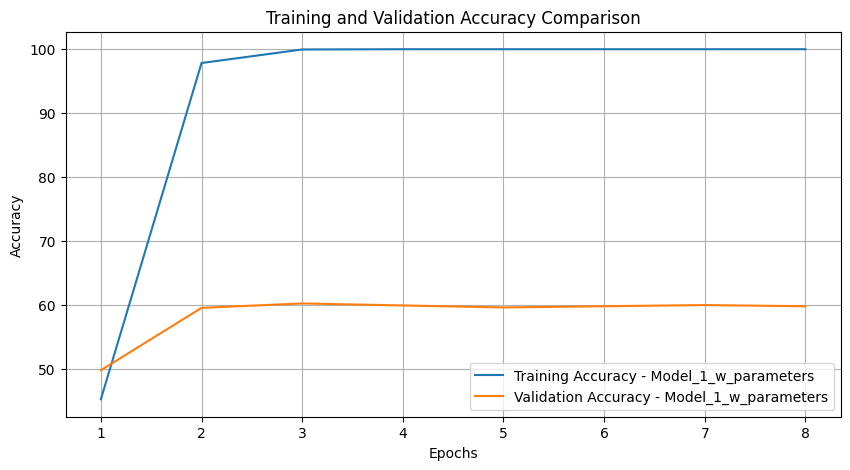

In [58]:
model_name ="Model_1_w_parameters"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)